<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Introduction to Deep Learning

## 10. Home Assignment II.

---

## B) Fashion MNIST

Build a convolutional network to classify the fashion mnist dataset. Build a function which will predict the class for an image. The function will get a path of an image as a parameter, it reads the image then returns the predicted class. You can assume that the path will always contain an image, which has *28 x 28 x 4* dimensions.

The dataset is available in [keras](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles). An example image is available at `data/fashion/test.png`.

### Table of Contents

* [Import libraries](#import-libraries)
  * [Set the seed](#set-seed)
* [Pre-processing](#pre-processing)
  * [Load and transform the dataset](#load-and-transform)
  * [Explore the dataset](#explore)
* [Network layout](#network-layout)
  * [Create a baseline network](#create-baseline)
  * [Convolutional networks](#convolutional-networks)
  * [Compare models](#compare-models)
* [Image class prediction](#predict-class)

### Import libraries <a class="anchor" id="import-libraries"></a>

In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adadelta
from keras.utils.vis_utils import plot_model
from network_functions import network_build, compile_fit_evaluate_network
from skimage import io

#### Set the seed <a class="anchor" id="set-seed"></a>

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Pre-processing <a class="anchor" id="pre-processing"></a>

#### Load and transform the dataset <a class="anchor" id="load-and-transform"></a>

In [3]:
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

In [4]:
print('Training examples: {}\nTesting examples: {}\nSize of the images: {}\nOutput classes: {}'.
      format(len(X_train), len(X_test), X_train[0].shape, len(set(y_train))))

Training examples: 60000
Testing examples: 10000
Size of the images: (28, 28)
Output classes: 10


There are 60,000 training examples, 10,000 testing examples in the dataset. Each image has a size of 28x28 pixels, and there are 10 output classes, just like in case of the Silent MNIST dataset. Let's look at one of the `X_train` values:

In [5]:
print('Array of values for X_train[0]:\n{}\nMinimum value: {}\nMaximum value: {}'.
      format(X_train[0], np.array(X_train[0]).min(), np.array(X_train[0]).max()))

Array of values for X_train[0]:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   

Based on the values (ranging from 0 to 255), it looks like we're dealing with colored images. In order to rescale these RGB values to grayscale values, I have to divide each of them by 255.

I'm going to train a dense network as my baseline, and for that I have to do some additional formatting. For ease of interpretation, I'll also use these transformed sets for data exploration. _Note:_ All variables and datasets that were solely created for the dense layer are given an `_d` suffix.

In [6]:
X_train = X_train / 255
X_test = X_test / 255

input_dim_d = 28 * 28
X_train_d = X_train.flatten().reshape(len(X_train), input_dim_d)
X_test_d = X_test.flatten().reshape(len(X_test), input_dim_d)

print('Shape of X_train_d: ', X_train_d.shape)

Shape of X_train_d:  (60000, 784)


Let's look at the target variables (`y_train`) to see if any transformation is needed:

In [7]:
print('Unique values in y_train: {}\nExample of a y value: y_train[0] = {}'.format(set(y_train), y_train[0]))

Unique values in y_train: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Example of a y value: y_train[0] = 9


The target variables are between 0 and 9, I'll transform these to one-hot encoded values.

In [8]:
output_dim = len(set(y_train))

y_train = to_categorical(y_train, output_dim)
y_test = to_categorical(y_test, output_dim)

print('Shape of y_train: ', y_train.shape)

Shape of y_train:  (60000, 10)


Let's see if the transformation was successful, we should see a `1.`, preceded by nine `0.`s.

In [9]:
print('y_train[0] in one-hot encoded form:', y_train[0], '\n\nShape of y_train[0]:', y_train[0].shape)

y_train[0] in one-hot encoded form: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 

Shape of y_train[0]: (10,)


#### Explore the dataset <a class="anchor" id="explore"></a>

Let's take a look at a few observations to get a sense of the data.

In [10]:
y_items = [0, 15000, 30000, 49000]
for y in y_items:
    print('y_train[{}] in one-hot encoded-form:'.format(y), y_train[y])

y_train[0] in one-hot encoded-form: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_train[15000] in one-hot encoded-form: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y_train[30000] in one-hot encoded-form: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y_train[49000] in one-hot encoded-form: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


So we're expecting to see four items of clothes that belong in completely different categories.

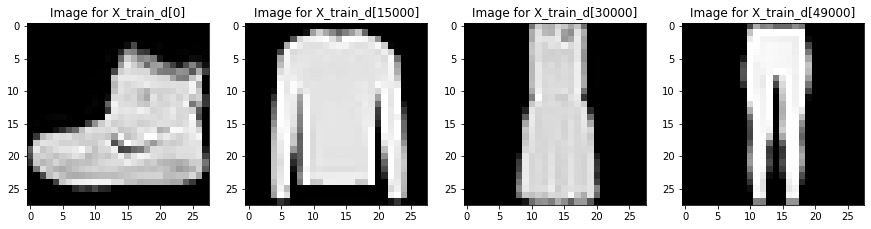

In [11]:
f, ax = plt.subplots(nrows=1, ncols=len(y_items), figsize=(15, 15))
for y in y_items:
    pos = y_items.index(y)  
    ax[pos].imshow(X_train_d[y].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax[pos].title.set_text('Image for X_train_d[{}]'.format(y))

The first image is a shoe, the second one is a T-shirt, the third one is I can only assume a dress, while the fourth one looks like a pair of jeans. Which means our assumption was correct, these do belong in seperate categories, although the resolution is visibly worse then it was for the 64x64 pixel images of the Silent MNIST dataset.

Now that I reshaped the data and have a solid idea about the dataset, I can get to building some networks.

### Network layout <a class="anchor" id="network-layout"></a>

#### Create a baseline network <a class="anchor" id="create-baseline"></a>

As I mentioned, for my baseline network, I will take the dense network that performed best for my submission for the first home assignment ([GitHub repo](https://github.com/szigony/ceu-dl-with-python/blob/master/assignments/Patrik_Szigeti-DL_05_Home_Assignment_1.ipynb)), and see if I can improve on that with convolutional neural networks. 

I'm using two functions that I built for the first assignment, `network_build` to build the network, and `compile_fit_evaluate_network` that compiles, fits and evaluates the model. They're both imported from the `network_functions` helper file.

In [12]:
model_bl, model_bl_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=3, 
        dense_units=[512, 128, 32],
        dropout_layers=False,
        input_dim=input_dim_d,
        output_dim=output_dim
    ),
    X_train=X_train_d,
    y_train=y_train,
    X_test=X_test_d,
    y_test=y_test,
    epochs=15,
    num_of_repeats=3
)

model_accuracies = {}
model_accuracies.update({'model_bl': {'model': model_bl, 'accuracy': model_bl_accuracy}})

The overall accuracy of the model on the test set is 88.23%


My baseline actually performs better for this dataset than it did for Silent MNIST, which is always good to see. Now I'll see if I can improve upon this with a convolutional network.

#### Convolutional networks <a class="anchor" id="convolutional-networks"></a>

I have previously trained convolutional networks for a similar dataset using R, I'll use the specifications of my best model from there for my baseline convolutional network. I also have to slightly reshape my `X_train` and `X_test` by adding the channel information.

In [13]:
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

print('Shape of X_train: {}\nShape of X_test: {}\nShape of y_train: {}'.format(X_train.shape, X_test.shape, y_train.shape))

Shape of X_train: (60000, 28, 28, 1)
Shape of X_test: (10000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [14]:
input_shape = (28, 28, 1)
loss_function = 'categorical_crossentropy'
metrics = ['accuracy']
num_of_repeats = 3

This time I'm not creating a separate function for building the model, but for compiling, fitting and evaluating I will, given I'm not changing much in those steps for the four networks I'm creating. To account for the randomness introduced by the dropout layer, I'm running each process `num_of_repeats` times and taking the accuracies' average as my final accuracy figure.

In [18]:
def cfe(model, X_train, y_train, X_test, y_test, num_of_repeats=3, loss_function='categorical_crossentropy', 
        optimizer=RMSprop(), metrics=['accuracy'], epochs=15, batch_size=128, validation_split=0.2):
    '''This function compiles, fits and evaluates the network repeated N number of times, 
    and takes the average of their accuracy as the final metric, also known as grand average.'''
    
    accuracies = []
    for i in range(0, num_of_repeats):
        model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=False)
        model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=False)
        accuracies.append(model_accuracy)

    grand_mean = np.mean(accuracies)
    print(f'The accuracy of the model on the test set is {grand_mean:.2%}')
    
    return model, grand_mean

`model_1`: I'm creating my first model with:
* Convolutional layer with 3x3 receptive field, 32 filters and `relu` activation
* MaxPooling layer with 2x2 pool layer
* Dropout layer with a ratio of 0.25
* Flattening
* Dense layer with 32 units and `relu` activation
* Dense layer with `softmax` activation

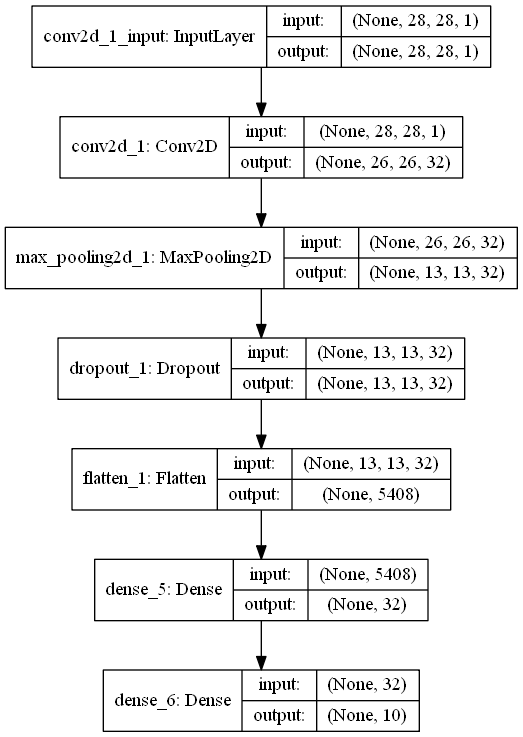

In [16]:
m1_model = Sequential()
m1_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
m1_model.add(MaxPooling2D(pool_size=(2, 2)))
m1_model.add(Dropout(rate=0.25))
m1_model.add(Flatten())
m1_model.add(Dense(units=32, activation='relu'))
m1_model.add(Dense(units=output_dim, activation='softmax'))

plot_model(m1_model, show_shapes=True, show_layer_names=True)

In [19]:
m1_model, m1_accuracy = cfe(
    model=m1_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'m1_model': {'model': m1_model, 'accuracy': m1_accuracy}})

The accuracy of the model on the test set is 91.38%


`model_2`: For my second model, I'm including an extra convolutional layer before `MaxPooling2D` and increasing the number of units in the penultimate dense layer to 128, which is the batch size I'm using when fitting the model. Everything else remains intact, as I'm already above 90% accuracy.

In [20]:
m2_model = Sequential()
m2_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
m2_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
m2_model.add(MaxPooling2D(pool_size=(2, 2)))
m2_model.add(Dropout(rate=0.25))
m2_model.add(Flatten())
m2_model.add(Dense(units=128, activation='relu'))
m2_model.add(Dense(units=output_dim, activation='softmax'))

m2_model, m2_accuracy = cfe(
    model=m2_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'m2_model': {'model': m2_model, 'accuracy': m2_accuracy}})

The accuracy of the model on the test set is 92.32%


`model_3`: For my third model, I'm trying to fine-tune my already pretty high accuracy from `model_2` by adding a dropout layer with `rate=0.5` between the two dense layers.

In [21]:
m3_model = Sequential()
m3_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
m3_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
m3_model.add(MaxPooling2D(pool_size=(2, 2)))
m3_model.add(Dropout(rate=0.25))
m3_model.add(Flatten())
m3_model.add(Dense(units=128, activation='relu'))
m3_model.add(Dropout(rate=0.5))
m3_model.add(Dense(units=output_dim, activation='softmax'))

m3_model, m3_accuracy = cfe(
    model=m3_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'m3_model': {'model': m3_model, 'accuracy': m3_accuracy}})

The accuracy of the model on the test set is 91.78%


`model_4`: For my fourth model, since adding an extra dropout layer didn't improve the performance, I'm keeping everything as it was for `model_2`, but changing the optimizer to `Adadelta`, which has parameter-specific learning rates that are adapted relative to how frequently a parameter gets updated during traning (idea based on Roan Gylberth's [article](https://medium.com/konvergen/continuing-on-adaptive-method-adadelta-and-rmsprop-1ff2c6029133)).

In [22]:
m4_model, m4_accuracy = cfe(
    model=m2_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimizer=Adadelta()
)

model_accuracies.update({'m4_model': {'model': m4_model, 'accuracy': m4_accuracy}})

The accuracy of the model on the test set is 92.59%


#### Compare models <a class="anchor" id="compare-models"></a>

I'm comparing the grand means of my five models to determine which one performed best, and which one to save for later use.

In [25]:
df_model_accuracies = pd.DataFrame(data=model_accuracies).T
df_model_accuracies

,model,accuracy
model_bl,<keras.engine.sequential.Sequential object at ...,0.882267
m1_model,<keras.engine.sequential.Sequential object at ...,0.913767
m2_model,<keras.engine.sequential.Sequential object at ...,0.923233
m3_model,<keras.engine.sequential.Sequential object at ...,0.917833
m4_model,<keras.engine.sequential.Sequential object at ...,0.9259


In [26]:
highest_accuracy = max(df_model_accuracies['accuracy'])
highest_accuracy_model = ''.join(df_model_accuracies[df_model_accuracies['accuracy'] == highest_accuracy].index.tolist())
               
print('The highest accuracy is ' + '{:.2%}'.format(highest_accuracy) + ', which belongs to ' + highest_accuracy_model + '.')

The highest accuracy is 92.59%, which belongs to m4_model.


So `Adadelta` performed slightly better than `RMSprop`. I'll use `model_4` for my predictive function.

In [29]:
model = df_model_accuracies.loc[highest_accuracy_model]['model']

### Image class prediction <a class="anchor" id="predict-class"></a>

The function:
* Takes a path of an image as a parameter
* Reads the image (28x28x4 dimensions)
* Trasforms it to the necessary format so that the model can consume it
* Returns the predicted class

In [80]:
fashion_classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 
                   7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [94]:
def predict_fashion(img_path, model=model):
    '''This function takes an image with 28x28x4 dimensions, transforms it to 4-dimensional grayscale for the model, 
    and predicts which class the specified image most likely belongs to from the Fashion MNIST dataset.'''
    
    img = (np.expand_dims(io.imread(img_path, as_gray=True), 0))
    img = img.reshape(*img.shape, 1)
    
    return('According to the model, this image most likely contains a(n) {}.'.
           format(fashion_classes[model.predict_classes(img)[0]]))

In [95]:
predict_fashion('data/fashion/test.png')

'According to the model, this image most likely contains a(n) Shirt.'